In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #but I want /MyDrive/Lasenet as well, so I don't have to put this infront of every file name
import os
os.chdir("/content/gdrive/MyDrive/LaseNets/")

Mounted at /content/gdrive


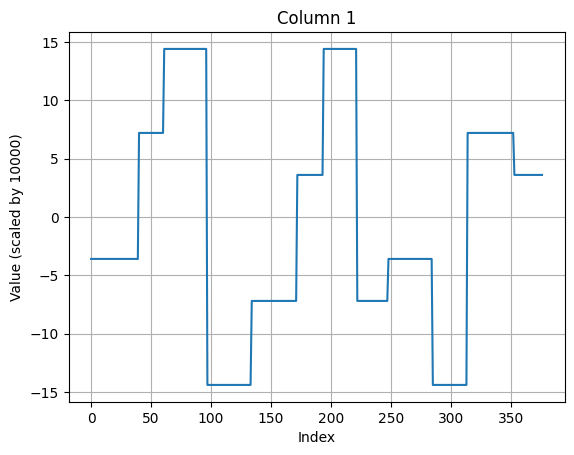

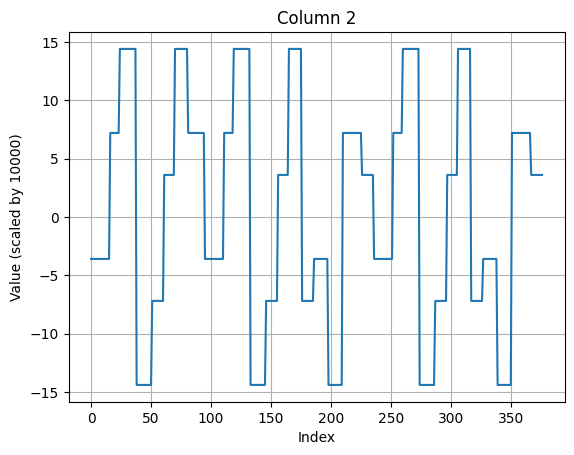

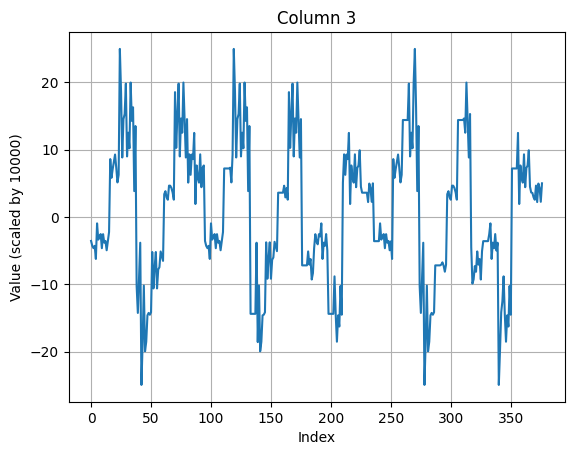

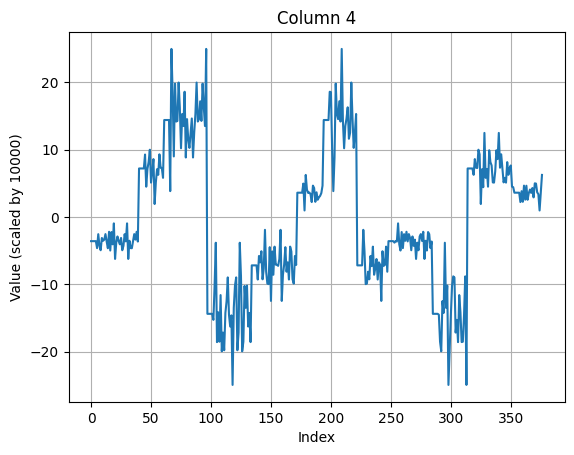

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

actual_reward_df = pd.read_excel("Wind_Conditions.xlsx", header=None)
actual_reward_df = actual_reward_df * 10000
for i in range(actual_reward_df.shape[1]):
    plt.figure()
    plt.plot(actual_reward_df.index, actual_reward_df.iloc[:, i])
    plt.xlabel("Index")
    plt.ylabel("Value (scaled by 10000)")
    plt.title(f"Column {i + 1}")
    plt.grid(True)
    plt.show()


--- Processing Motor Data ---

--- Processing NonMotor Data ---

--- Summary Metrics ---
Motor Group MSE (Avg Kalman vs Avg Perceived): 6.3506
NonMotor Group MSE (Avg Kalman vs Avg Perceived): 7.7997


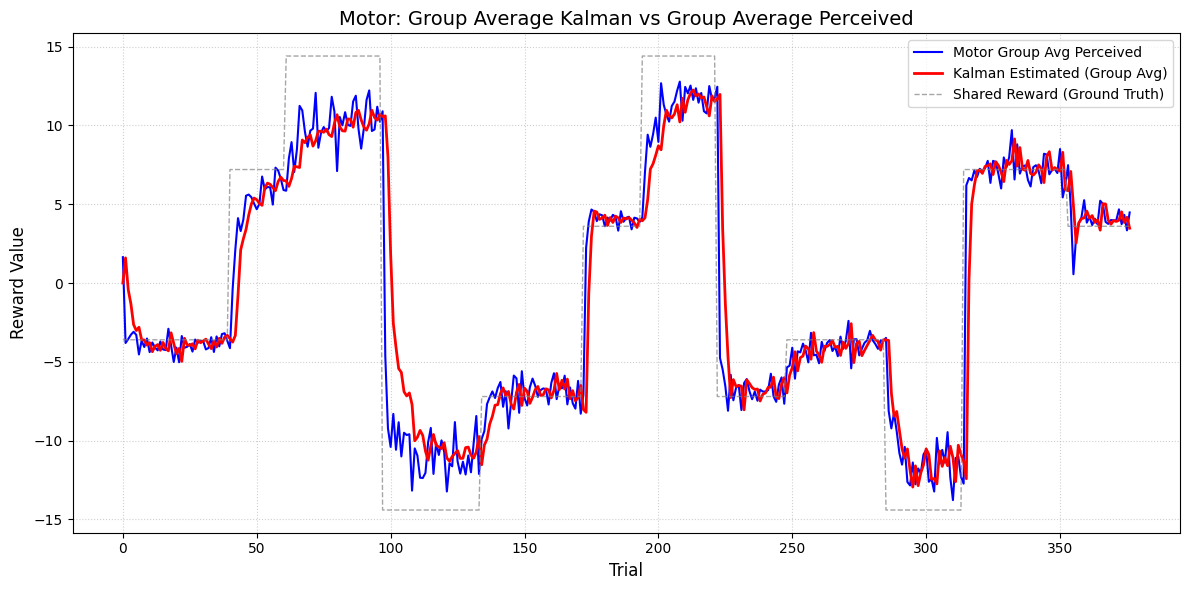

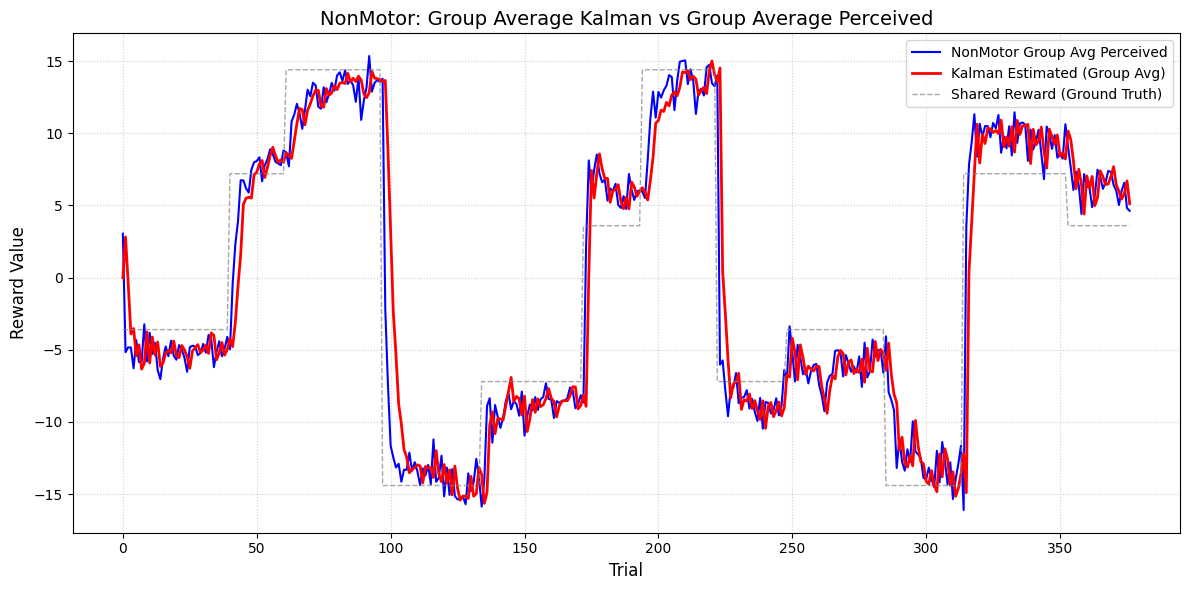


Finished generating group average plots and calculating MSEs.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats # For correlation if we want it later

# --- Global Kalman Parameters ---
initial_uncertainty = 1.0 # Initial uncertainty (w[0]) of the reward estimate
use_initial_reward = False # Whether to initialize m[0] with the first observed reward or 0.0

# --- 1. Load Shared Environment Rewards (Ground Truth) ---
shared_rewards_ground_truth_df = pd.read_excel("Wind_Conditions.xlsx", header=None)
shared_rewards_ground_truth = shared_rewards_ground_truth_df[0].to_numpy() * 10000

# --- 2. Function to Process and Run Kalman for a Specific Behavior Type ---

def process_and_run_kalman_individual(
    vol_file_path,
    stoch_file_path,
    perceived_file_path,
    behavior_type # e.g., "Motor" or "NonMotor"
):
    print(f"\n--- Processing {behavior_type} Data ---")

    # Load predicted volatility and stochasticity (should contain agent_id, trial)
    vol_df = pd.read_excel(vol_file_path)
    stoch_df = pd.read_excel(stoch_file_path)

    # Load participant-perceived reward data (ASSUMED: Trials as rows, Participants as columns)
    participant_perceived_df = pd.read_excel(perceived_file_path, header=None)
    participant_perceived_df = participant_perceived_df * 10000 / (-270) # Scale
    participant_perceived_df = participant_perceived_df.clip(lower=-25, upper=25) # Clip

    # Determine dimensions based on shared_rewards (ground truth trials)
    # Using ground truth to determine max trials, then trim perceived data to match
    n_trials_behavior = shared_rewards_ground_truth.shape[0]
    n_agents_behavior = participant_perceived_df.shape[1]

    # Ensure participant perceived data matches n_trials, trim if longer
    if participant_perceived_df.shape[0] > n_trials_behavior:
        participant_perceived_df = participant_perceived_df.iloc[:n_trials_behavior, :]
    elif participant_perceived_df.shape[0] < n_trials_behavior:
        print(f"Warning: {behavior_type} perceived data has fewer trials ({participant_perceived_df.shape[0]}) than ground truth ({n_trials_behavior}). Truncating ground truth to match.")
        n_trials_behavior = participant_perceived_df.shape[0]
        # Adjust ground truth rewards if needed, only use the relevant part
        # Note: current_shared_rewards will be used for ground_truth_long creation
        current_shared_rewards_for_gt = shared_rewards_ground_truth[:n_trials_behavior]
    else:
        current_shared_rewards_for_gt = shared_rewards_ground_truth


    # Create long format DataFrames for merging all data
    agent_ids_long = np.repeat(np.arange(n_agents_behavior), n_trials_behavior)
    trial_nums_long = np.tile(np.arange(n_trials_behavior), n_agents_behavior)

    # Create long format for ground truth reward (repeated for each agent)
    ground_truth_long = pd.DataFrame({
        'agent_id': agent_ids_long,
        'trial': trial_nums_long,
        'ground_truth_reward': np.tile(current_shared_rewards_for_gt, n_agents_behavior)
    })

    # Flatten participant-perceived data into long format
    # Transpose first to flatten agent by agent (column-wise)
    perceived_flat = participant_perceived_df.to_numpy().T.flatten()
    participant_perceived_long = pd.DataFrame({
        'agent_id': agent_ids_long,
        'trial': trial_nums_long,
        'participant_perceived_reward': perceived_flat
    })

    # Merge all relevant data into a single DataFrame
    df_merged = vol_df.merge(stoch_df, on=['agent_id', 'trial'], how='inner')
    df_merged = df_merged.merge(ground_truth_long, on=['agent_id', 'trial'], how='inner')
    df_merged = df_merged.merge(participant_perceived_long, on=['agent_id', 'trial'], how='inner')

    # Ensure the combined dataframe is sorted for Kalman filter processing
    df_merged = df_merged.sort_values(by=['agent_id', 'trial']).reset_index(drop=True)

    # Initialize a new column for Kalman estimated reward
    df_merged['estimated_reward'] = np.nan

    # --- Run Kalman Filter for Each Agent ---
    if df_merged.empty:
        print(f"Warning: Merged DataFrame for {behavior_type} is empty. Cannot run Kalman filter.")
        return pd.DataFrame(), None # Return empty df and None for avg_perceived

    # Loop through each unique agent to apply the Kalman filter individually
    for agent_id, group in df_merged.groupby('agent_id'):
        original_index = group.index
        group = group.reset_index(drop=True) # Reset index for sequential access
        T = len(group) # Number of trials for the current agent

        m = np.zeros(T)
        w = np.zeros(T)

        if T > 0:
            # Set initial estimated reward m[0] using *this agent's* first perceived reward
            m[0] = group.loc[0, 'participant_perceived_reward'] if use_initial_reward else 0.0
            w[0] = initial_uncertainty
        else:
            print(f"Warning: Agent {agent_id} group in {behavior_type} is empty. Skipping Kalman for this agent.")
            continue # Skip to next agent if group is empty

        for t in range(T - 1):
            # The observation 'o' is the *individual participant's perceived reward* for this agent
            o = group.loc[t, 'participant_perceived_reward']

            v = np.clip(group.loc[t, 'predicted_volatility'], 1e-6, None)
            s = np.clip(group.loc[t, 'predicted_stochasity'], 1e-6, None)

            alpha = (w[t] + v) / (w[t] + v + s)
            m[t + 1] = m[t] + alpha * (o - m[t])
            w[t + 1] = (1 - alpha) * (w[t] + v)

        # Assign the calculated estimated rewards back to the main DataFrame
        df_merged.loc[original_index, 'estimated_reward'] = m

    # Calculate the average perceived reward and average Kalman estimation across agents
    # Group by trial and then take the mean
    avg_perceived_reward = df_merged.groupby('trial')['participant_perceived_reward'].mean()
    avg_kalman_estimated = df_merged.groupby('trial')['estimated_reward'].mean()

    return avg_perceived_reward, avg_kalman_estimated


# --- 3. Process Motor and NonMotor Data ---

motor_avg_perceived, motor_avg_kalman = process_and_run_kalman_individual(
    "predicted_volatility_Motor_Simple.xlsx",
    "predicted_stochasity_Motor_Simple.xlsx",
    "Motor_LVLS.xlsx",
    "Motor"
)

nonmotor_avg_perceived, nonmotor_avg_kalman = process_and_run_kalman_individual(
    "predicted_volatility_NonMotor_Simple.xlsx",
    "predicted_stochasity_NonMotor_Simple.xlsx",
    "NonMotor_LVLS.xlsx",
    "NonMotor"
)

# --- 4. Calculate Group Average MSEs ---
if motor_avg_perceived is not None and motor_avg_kalman is not None and not motor_avg_perceived.empty:
    mse_motor_group = np.mean((motor_avg_perceived - motor_avg_kalman)**2)
    print(f"\n--- Summary Metrics ---")
    print(f"Motor Group MSE (Avg Kalman vs Avg Perceived): {mse_motor_group:.4f}")
else:
    mse_motor_group = np.nan
    print(f"\n--- Summary Metrics ---")
    print(f"Motor Group MSE: Not calculable (no data).")


if nonmotor_avg_perceived is not None and nonmotor_avg_kalman is not None and not nonmotor_avg_perceived.empty:
    mse_nonmotor_group = np.mean((nonmotor_avg_perceived - nonmotor_avg_kalman)**2)
    print(f"NonMotor Group MSE (Avg Kalman vs Avg Perceived): {mse_nonmotor_group:.4f}")
else:
    mse_nonmotor_group = np.nan
    print(f"NonMotor Group MSE: Not calculable (no data).")


# === 5. Plotting Group Averages ===

# Plot 1: Motor - Group Averages
plt.figure(figsize=(12, 6))
plt.plot(motor_avg_perceived, label='Motor Group Avg Perceived', color='blue', linewidth=1.5)
plt.plot(motor_avg_kalman, label='Kalman Estimated (Group Avg)', color='red', linewidth=2.0)
plt.plot(shared_rewards_ground_truth, label='Shared Reward (Ground Truth)', linestyle='--', color='gray', alpha=0.7, linewidth=1.0)

plt.title("Motor: Group Average Kalman vs Group Average Perceived", fontsize=14)
plt.xlabel("Trial", fontsize=12)
plt.ylabel("Reward Value", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 2: NonMotor - Group Averages
plt.figure(figsize=(12, 6))
plt.plot(nonmotor_avg_perceived, label='NonMotor Group Avg Perceived', color='blue', linewidth=1.5)
plt.plot(nonmotor_avg_kalman, label='Kalman Estimated (Group Avg)', color='red', linewidth=2.0)
plt.plot(shared_rewards_ground_truth, label='Shared Reward (Ground Truth)', linestyle='--', color='gray', alpha=0.7, linewidth=1.0)

plt.title("NonMotor: Group Average Kalman vs Group Average Perceived", fontsize=14)
plt.xlabel("Trial", fontsize=12)
plt.ylabel("Reward Value", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nFinished generating group average plots and calculating MSEs.")

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Data ---

# Load predicted volatility and stochasticity from RNN output
# These files should contain agent_id, trial, and the respective predicted values
vol_df = pd.read_excel("predicted_volatility_NonMotor_Simple (3).xlsx")
stoch_df = pd.read_excel("predicted_stochasity_NonMotor_Simple (3).xlsx")

# Load shared environment rewards (ground truth)
# This is typically a single column representing the objective reward over trials
actual_reward_df = pd.read_excel("Wind_Conditions.xlsx", header=None)
actual_reward_df = actual_reward_df * 10000 # Scale as per your description
shared_rewards = actual_reward_df[0].to_numpy() # Extract the numpy array for trials

# Load participant-perceived reward data
# This is expected to have trials as rows and participants as columns
participant_perceived_df = pd.read_excel("NonMotor_LVLS.xlsx", header=None)
participant_perceived_df = participant_perceived_df * 10000 / (-270) # Scale as per your description
participant_perceived_df = participant_perceived_df.clip(lower=-25, upper=25) # Clip as per your description

# --- 2. Data Preparation and Alignment ---

# Determine dimensions based on shared_rewards (ground truth trials)
n_trials = shared_rewards.shape[0] # Number of trials (e.g., 377)
n_agents = participant_perceived_df.shape[1] # Number of participants/agents (e.g., 23)

# Ensure participant perceived data matches n_trials, trim if longer
if participant_perceived_df.shape[0] > n_trials:
    participant_perceived_df = participant_perceived_df.iloc[:n_trials, :]
elif participant_perceived_df.shape[0] < n_trials:
    print(f"Warning: Participant perceived data has fewer trials ({participant_perceived_df.shape[0]}) than shared rewards ({n_trials}). Truncating shared rewards to match.")
    n_trials = participant_perceived_df.shape[0]
    shared_rewards = shared_rewards[:n_trials]

# Create long format DataFrames for merging all data
# These arrays will be used to create 'agent_id' and 'trial' columns for all data
agent_ids_long = np.repeat(np.arange(n_agents), n_trials)
trial_nums_long = np.tile(np.arange(n_trials), n_agents)

# Create long format for ground truth reward (repeated for each agent)
ground_truth_long = pd.DataFrame({
    'agent_id': agent_ids_long,
    'trial': trial_nums_long,
    'ground_truth_reward': np.tile(shared_rewards, n_agents)
})

# Flatten participant-perceived data into long format
# Transpose first to flatten agent by agent (column-wise)
perceived_flat = participant_perceived_df.to_numpy().T.flatten()
participant_perceived_long = pd.DataFrame({
    'agent_id': agent_ids_long,
    'trial': trial_nums_long,
    'participant_perceived_reward': perceived_flat
})

# Merge all relevant data into a single DataFrame
# This 'df' will contain all the necessary data for Kalman filter for each agent and trial
df = vol_df.merge(stoch_df, on=['agent_id', 'trial'])
df = df.merge(ground_truth_long, on=['agent_id', 'trial'])
df = df.merge(participant_perceived_long, on=['agent_id', 'trial'])

# Initialize new columns to store Kalman estimated reward and alpha
df['estimated_reward'] = np.nan
df['alpha'] = np.nan # New column for learning rate (alpha)

# --- 3. Kalman Filter Parameters ---

initial_uncertainty = 1.0 # Initial uncertainty (w[0]) of the reward estimate
use_initial_reward = False # Whether to initialize m[0] with the first observed reward or 0.0

# --- 4. Run Kalman Filter for Each Agent ---

# Lists to store metrics for each agent
all_agent_mses = []
all_agent_maes = []
all_agent_rmses = []

# Loop through each unique agent to apply the Kalman filter individually
for agent_id, group in df.groupby('agent_id'):
    # Store the original index to update the 'estimated_reward' column in the main DataFrame
    original_index = group.index
    # Reset index for easier sequential access within the group
    group = group.reset_index(drop=True)
    T = len(group) # Number of trials for the current agent

    # Initialize state estimate (m) and uncertainty (w) for the current agent
    m = np.zeros(T)
    w = np.zeros(T)
    alpha_vals = np.zeros(T) # Array to store alpha values for this specific agent

    # Set initial estimated reward m[0]
    m[0] = group.loc[0, 'participant_perceived_reward'] if use_initial_reward else 0.0
    w[0] = initial_uncertainty
    alpha_vals[0] = np.nan # Alpha is not defined for the first trial (no previous update based on observation)

    # Loop through trials to perform Kalman updates
    for t in range(T - 1):
        # The crucial change: 'o' (observation) is the *participant's perceived reward*
        o = group.loc[t, 'participant_perceived_reward']

        # Get predicted volatility and stochasticity for the current agent and trial
        # Clip values to avoid division by zero or negative uncertainties
        v = np.clip(group.loc[t, 'predicted_volatility'], 1e-6, None)
        s = np.clip(group.loc[t, 'predicted_stochasity'], 1e-6, None)

        # Handle potential NaNs in inputs to Kalman filter
        if np.isnan(o) or np.isnan(v) or np.isnan(s):
            alpha_val = np.nan # If any input is NaN, alpha becomes NaN
            m_t_plus_1 = np.nan # And subsequent estimates become NaN
            w_t_plus_1 = np.nan
        else:
            # Calculate Kalman Gain (alpha)
            alpha_val = (w[t] + v) / (w[t] + v + s)

            # Update reward estimate (m)
            m_t_plus_1 = m[t] + alpha_val * (o - m[t])

            # Update uncertainty (w)
            w_t_plus_1 = (1 - alpha_val) * (w[t] + v)

        m[t + 1] = m_t_plus_1
        w[t + 1] = w_t_plus_1
        alpha_vals[t + 1] = alpha_val

    # Assign the calculated estimated rewards and alpha back to the main DataFrame
    df.loc[original_index, 'estimated_reward'] = m
    df.loc[original_index, 'alpha'] = alpha_vals # Assign alpha values for this agent

    # --- Calculate Metrics for the current agent ---
    actual_perceived_agent = df.loc[original_index, 'participant_perceived_reward'].to_numpy()
    estimated_agent = df.loc[original_index, 'estimated_reward'].to_numpy()

    # Ensure no NaNs in data before MSE calculation
    valid_indices = ~np.isnan(actual_perceived_agent) & ~np.isnan(estimated_agent)

    if np.sum(valid_indices) > 0:
        # Filter out NaNs for calculation
        actual_valid = actual_perceived_agent[valid_indices]
        estimated_valid = estimated_agent[valid_indices]

        mse_agent = np.mean((actual_valid - estimated_valid)**2)
        mae_agent = np.mean(np.abs(actual_valid - estimated_valid))
        rmse_agent = np.sqrt(mse_agent)

        all_agent_mses.append(mse_agent)
        all_agent_maes.append(mae_agent)
        all_agent_rmses.append(rmse_agent)

        print(f"\nAgent {agent_id} Metrics:")
        print(f"  MSE: {mse_agent:.4f}")
        print(f"  MAE: {mae_agent:.4f}")
        print(f"  RMSE: {rmse_agent:.4f}")
    else:
        print(f"\nAgent {agent_id}: No valid data points for metric calculation.")


# --- 5. Save Results ---

output_filename = "final_estimated_reward_kalman_on_perceived_nonmotor.xlsx"
df.to_excel(output_filename, index=False)
print(f"✅ Saved results to {output_filename}")

# --- 6. Plotting for Each Agent (Reward Data) ---

print("\n--- Generating Individual Agent Reward Plots ---")
for agent_id in df['agent_id'].unique():
    agent_df = df[df['agent_id'] == agent_id]

    plt.figure(figsize=(12, 6))
    plt.plot(agent_df['trial'], agent_df['estimated_reward'], label='Kalman Estimated Reward (Model Output)', color='red', linewidth=1.5)
    plt.plot(agent_df['trial'], agent_df['participant_perceived_reward'], label='Actual Perceived Reward (Human Data)', color='blue', linewidth=1.5)
    plt.plot(agent_df['trial'], agent_df['ground_truth_reward'], label='Ground Truth Reward (Objective)', linestyle='--', color='gray', alpha=0.7, linewidth=1.0)

    plt.title(f"Agent {agent_id}: Kalman Estimated vs Actual Perceived Reward (NonMotor)", fontsize=14)
    plt.xlabel("Trial", fontsize=12)
    plt.ylabel("Reward Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 7. Plotting Average Across All Agents (Reward Data) ---

print("\n--- Generating Average Reward Plot Across All Agents ---")

# Calculate the average of relevant columns across all agents for each trial
average_estimated_reward = df.groupby('trial')['estimated_reward'].mean()
average_perceived_reward = df.groupby('trial')['participant_perceived_reward'].mean()
# Ground truth is the same for all, so we can just take it from one agent or calculate the mean
ground_truth_for_plot = df.groupby('trial')['ground_truth_reward'].mean()

plt.figure(figsize=(12, 6))
plt.plot(average_estimated_reward.index, average_estimated_reward.values, label='Average Kalman Estimated Reward', color='red', linewidth=2.0)
plt.plot(average_perceived_reward.index, average_perceived_reward.values, label='Average Perceived Reward (Human Data)', color='blue', linewidth=2.0)
plt.plot(ground_truth_for_plot.index, ground_truth_for_plot.values, label='Ground Truth Reward (Objective)', linestyle='--', color='gray', alpha=0.8, linewidth=1.5)

plt.title("Average Rewards Across All Agents (NonMotor)", fontsize=14)
plt.xlabel("Trial", fontsize=12)
plt.ylabel("Reward Value", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


# --- 8. Calculate and Print Mean of All Agent Metrics ---
print(f"\n--- Overall Summary ---")
if all_agent_mses: # Check if the lists are not empty
    mean_mse_across_agents = np.mean(all_agent_mses)
    mean_mae_across_agents = np.mean(all_agent_maes)
    mean_rmse_across_agents = np.mean(all_agent_rmses)

    print(f"Mean MSE across all agents: {mean_mse_across_agents:.4f}")
    print(f"Mean MAE across all agents: {mean_mae_across_agents:.4f}")
    print(f"Mean RMSE across all agents: {mean_rmse_across_agents:.4f}")
else:
    print("No metrics were calculated for agents.")

# --- 9. Plot Average Learning Rate (Alpha) ---
# This remains a group-average plot as requested previously
average_alpha = df.groupby('trial')['alpha'].mean()

plt.figure(figsize=(12, 6))
plt.plot(average_alpha.index, average_alpha.values, label='Average Learning Rate (Alpha)', color='purple', linewidth=2.0)
plt.title("Average Kalman Learning Rate (Alpha) Over Trials", fontsize=14)
plt.xlabel("Trial", fontsize=12)
plt.ylabel("Alpha Value", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


# --- 10. Plot Learning Rate (Alpha) for Each Agent Separately ---

print("\n--- Generating Individual Agent Learning Rate (Alpha) Plots ---")
for agent_id in df['agent_id'].unique():
    agent_df = df[df['agent_id'] == agent_id]

    plt.figure(figsize=(12, 6))
    # Only plot non-NaN alpha values if the first trial is NaN
    plt.plot(agent_df['trial'].iloc[1:], agent_df['alpha'].iloc[1:], label=f'Agent {agent_id} Learning Rate (Alpha)', color='green', linewidth=1.5)

    plt.title(f"Agent {agent_id}: Kalman Learning Rate (Alpha) Over Trials", fontsize=14)
    plt.xlabel("Trial", fontsize=12)
    plt.ylabel("Alpha Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()


print("\nFinished generating all plots and summary metrics.")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for agent_id in df['agent_id'].unique():
    agent_df = df[df['agent_id'] == agent_id]
    print(f"Agent {agent_id} — estimated reward range:",
          agent_df['estimated_reward'].min(),
          agent_df['estimated_reward'].max())

    plt.figure(figsize=(10, 4))
    plt.plot(agent_df['trial'], agent_df['estimated_reward'], label='Estimated Reward')
    plt.plot(agent_df['trial'], agent_df['participant_perceived_reward'], label='Actual Perceived Reward')
    plt.title(f"Agent {agent_id}: Estimated vs Perceived Reward for NonMotor Behavior")
    plt.xlabel("Trial")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 🔽 Save the plot as PNG
    plt.savefig(f"agent_{agent_id}_reward_plot.png", dpi=300)

    # Optional: also show it
    plt.show()

import zipfile
import os
from google.colab import files

with zipfile.ZipFile("all_agent_plots_NonMotor.zip", "w") as zipf:
    for agent_id in df['agent_id'].unique():
        filename = f"agent_{agent_id}_reward_plot.png"
        if os.path.exists(filename):
            zipf.write(filename)

files.download("all_agent_plots_NonMotor.zip")

Output hidden; open in https://colab.research.google.com to view.

✅ Saved to final_estimated_reward_with_perceived.xlsx
Agent 0 — estimated reward range: -24.091783549408383 24.057839247443887


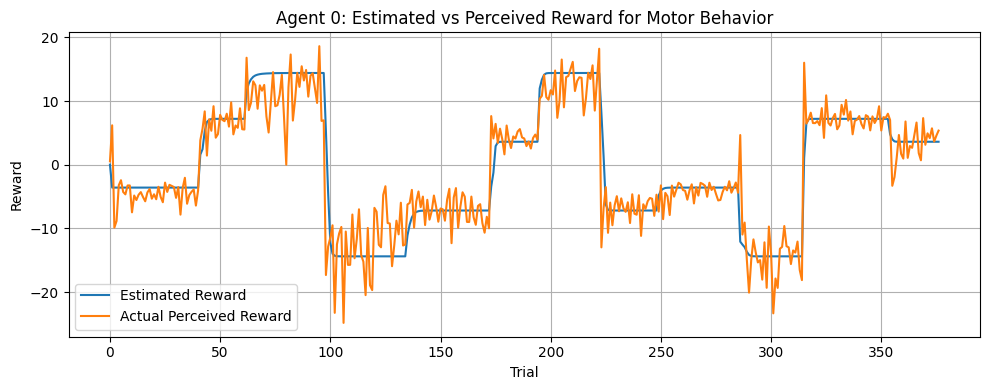

Agent 1 — estimated reward range: -14.4 14.399999999999997


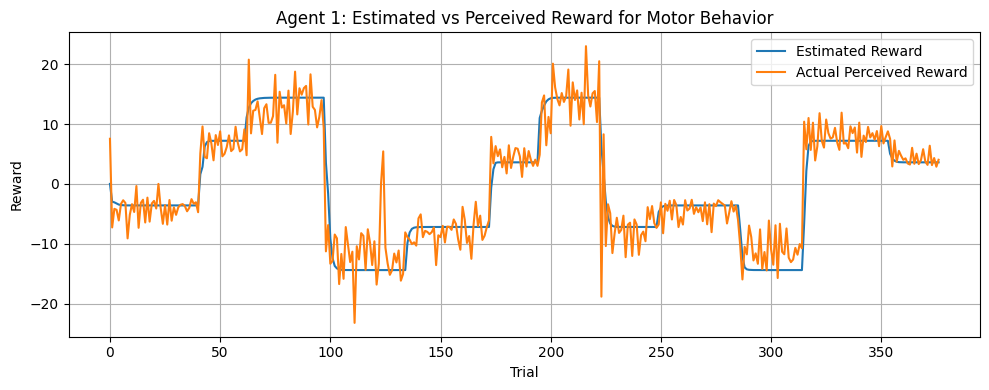

Agent 2 — estimated reward range: -14.399999999945448 14.399999999997256


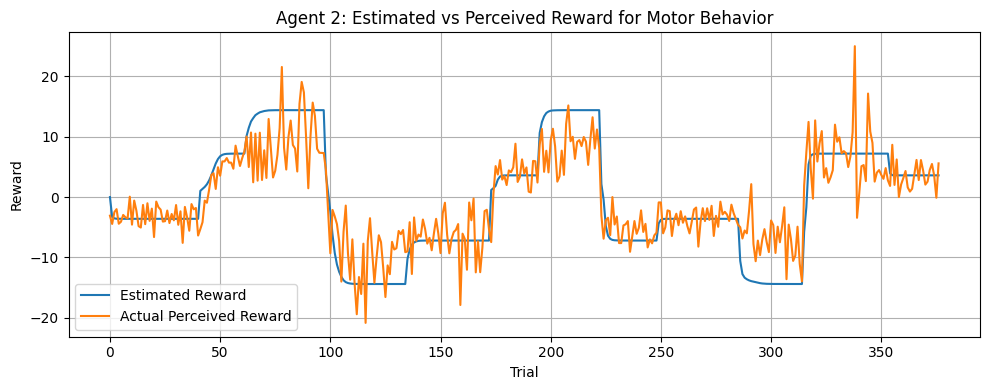

Agent 3 — estimated reward range: -14.399999999993545 14.4


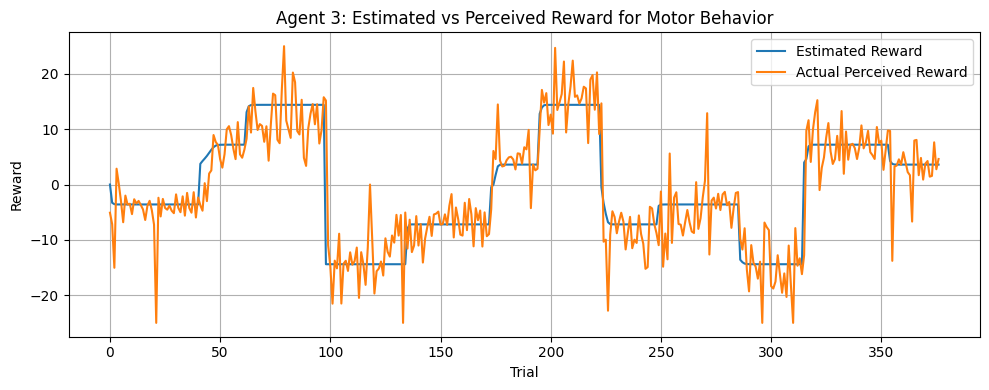

Agent 4 — estimated reward range: -14.4 14.4


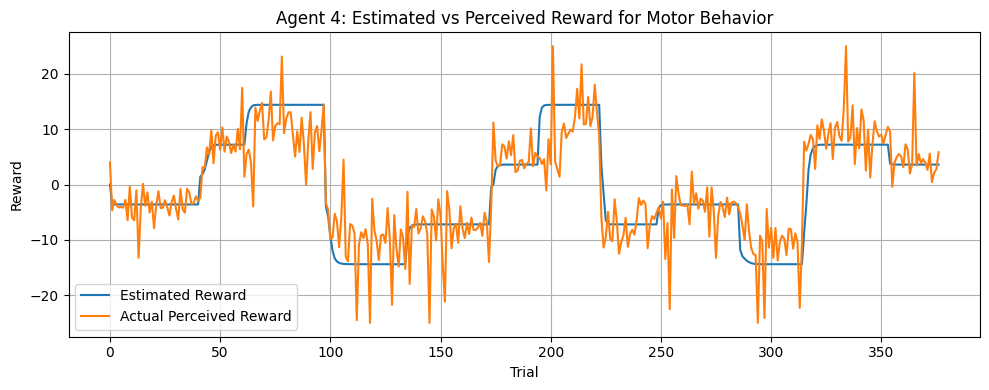

Agent 5 — estimated reward range: -14.4 14.4


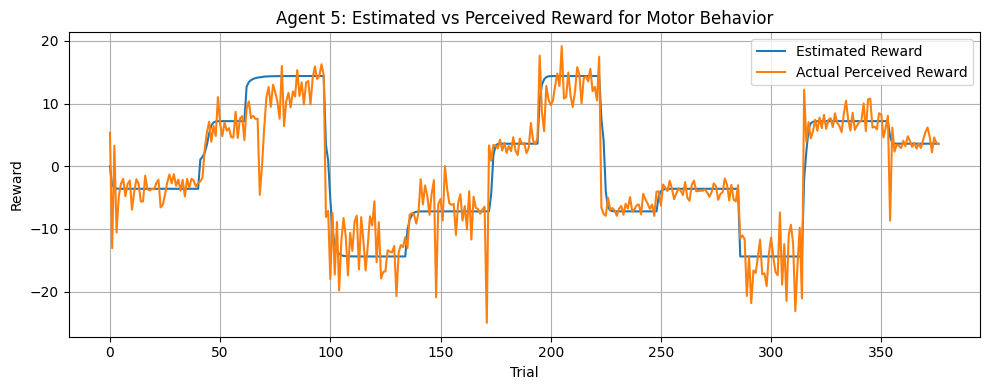

Agent 6 — estimated reward range: -14.4 14.399999999991284


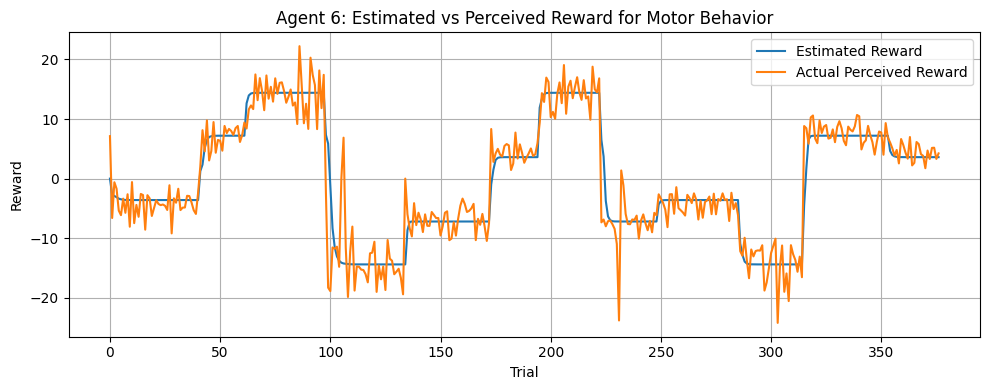

Agent 7 — estimated reward range: -14.4 14.4


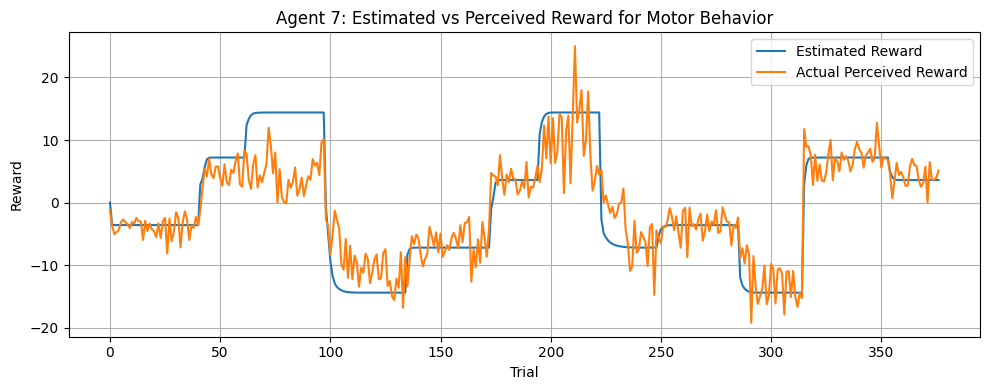

Agent 8 — estimated reward range: -14.4 14.4


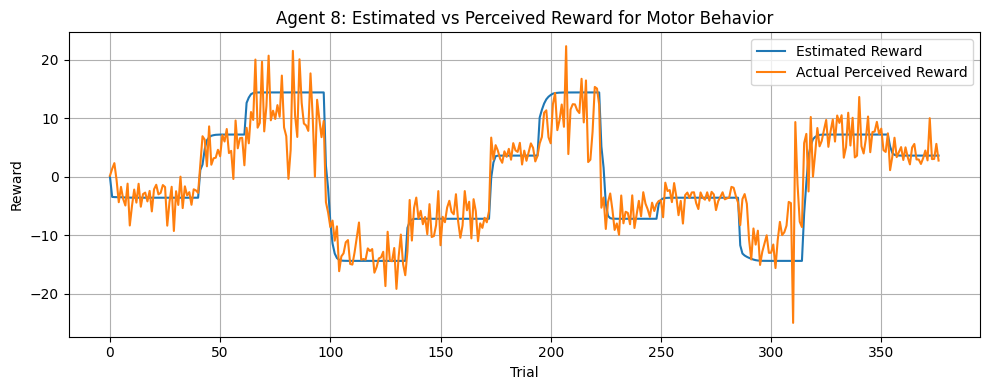

Agent 9 — estimated reward range: -14.4 14.4


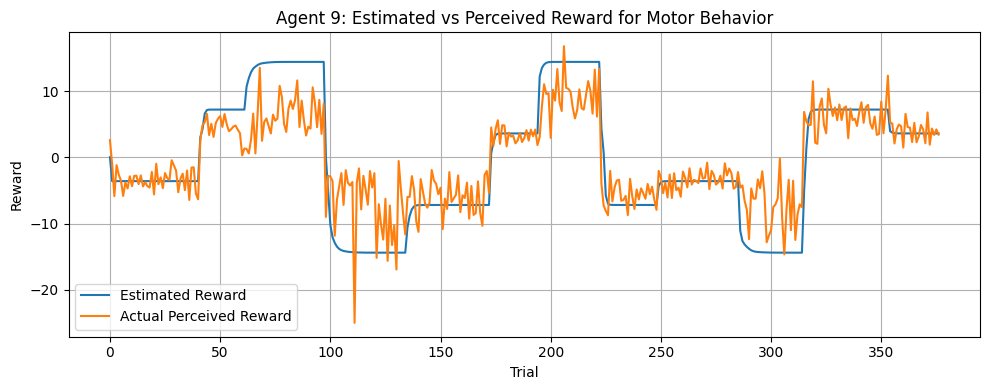

Agent 10 — estimated reward range: -14.399999976477185 14.399999999999416


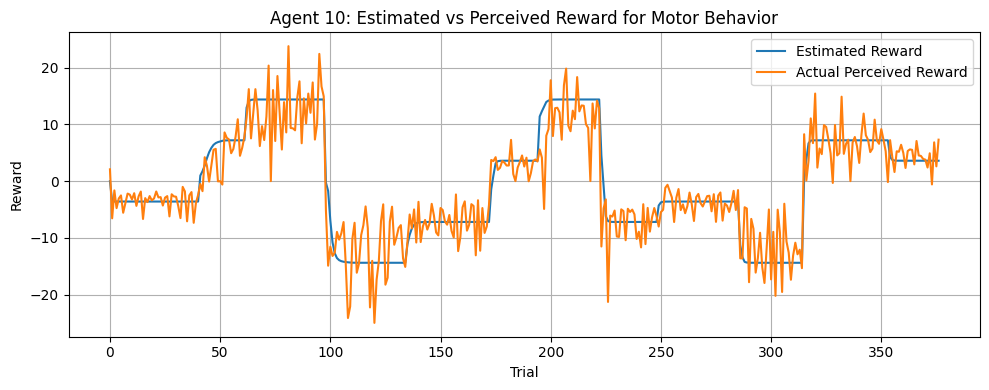

Agent 11 — estimated reward range: -14.4 14.399999999996167


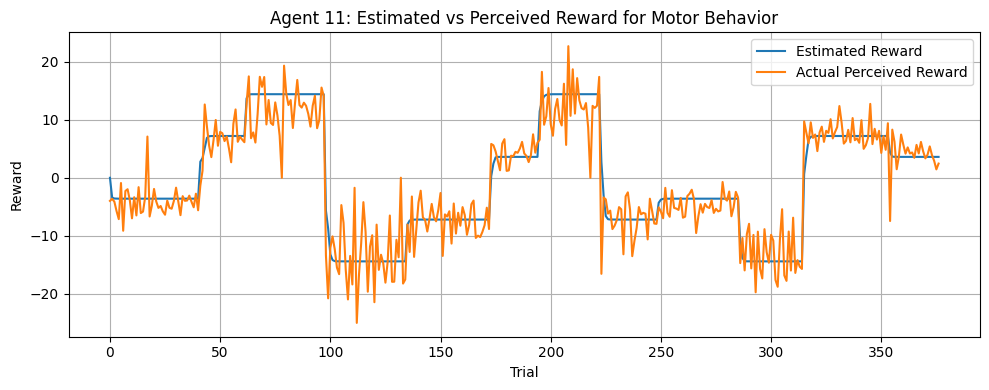

Agent 12 — estimated reward range: -14.4 14.4


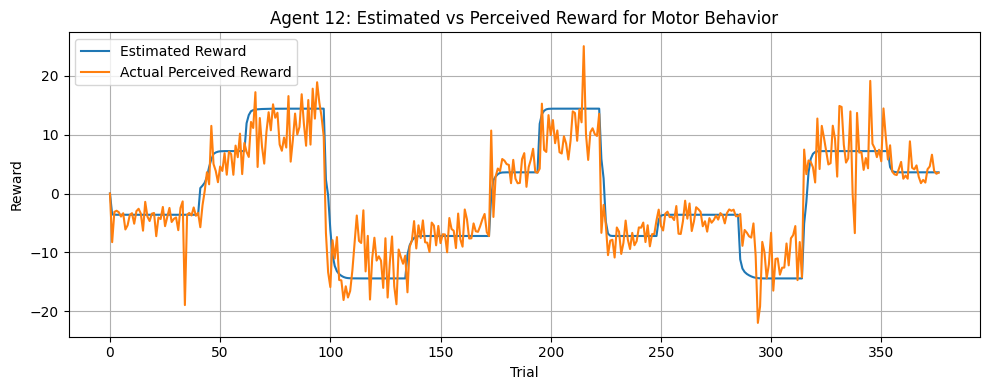

Agent 13 — estimated reward range: -14.4 14.399999999999991


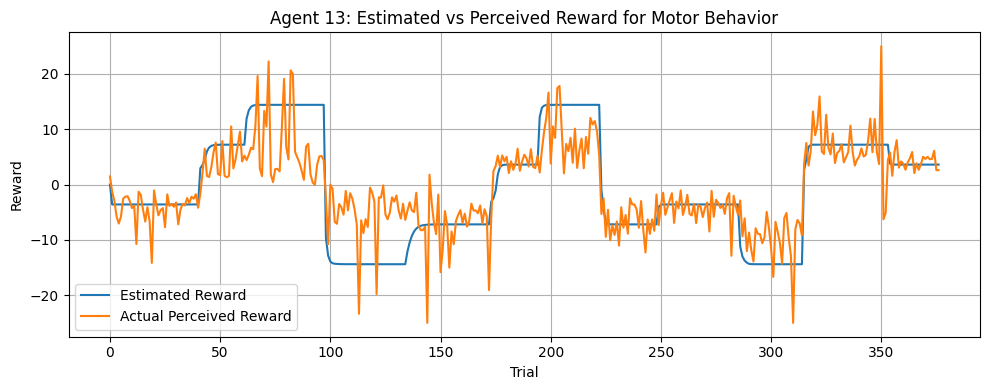

Agent 14 — estimated reward range: -14.4 14.4


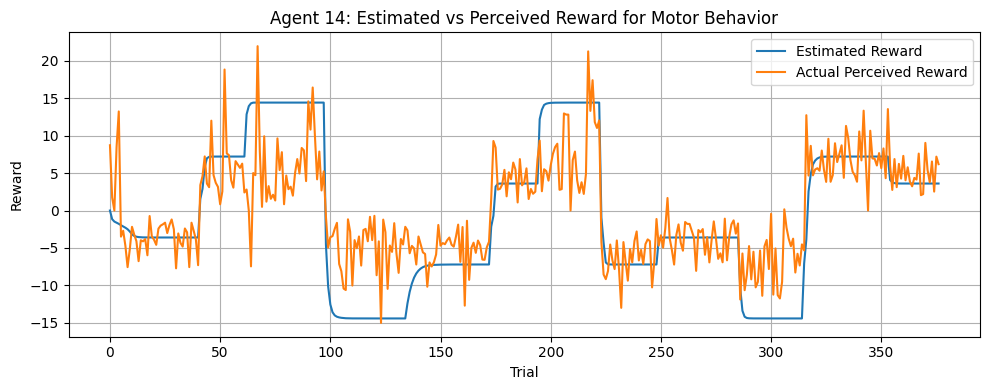

Agent 15 — estimated reward range: -14.39999818794522 14.399999999999997


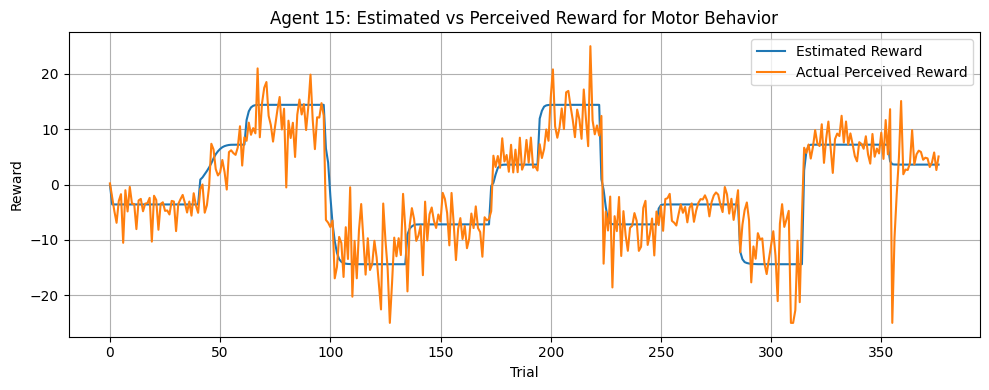

Agent 16 — estimated reward range: -14.4 14.4


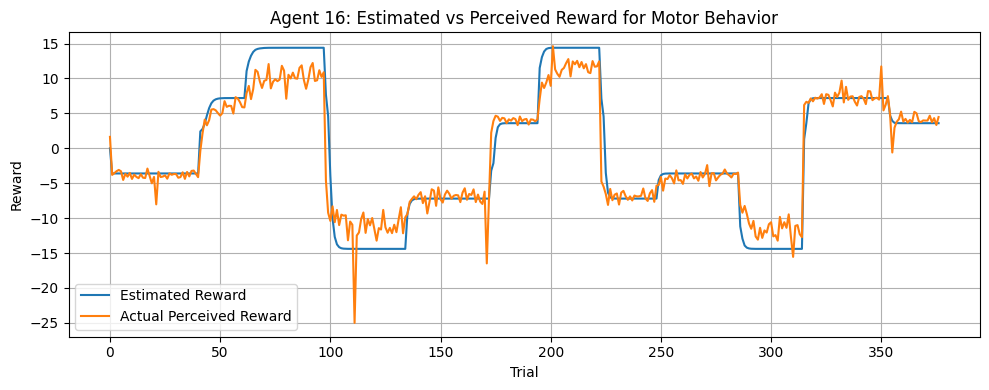

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load predicted volatility and stochasticity
vol_df = pd.read_excel("predicted_volatility_Motor_Simple (4).xlsx")  # columns: agent_id, trial, predicted_volatility
stoch_df = pd.read_excel("predicted_stochasity_Motor_Simple (4).xlsx")  # columns: agent_id, trial, predicted_stochasticity

# Load shared environment rewards (single-column, 377 time steps)
actual_reward_df = pd.read_excel("Wind_Conditions.xlsx", header=None)
actual_reward_df = actual_reward_df * 10000
shared_rewards = actual_reward_df[0].to_numpy()  # shape: (377,)

# Load participant-perceived reward: (should be at least 377 rows, 23 columns)
participant_perceived_df = pd.read_excel("Motor_LVLS.xlsx", header=None)
participant_perceived_df = participant_perceived_df * 10000 / (-270)
participant_perceived_df = participant_perceived_df.clip(lower=-25, upper=25)

# Trim to 377 trials if necessary
participant_perceived_df = participant_perceived_df.iloc[:377, :]  # shape: (377, 23)
#participant_perceived_df = participant_perceived_df.rolling(window=7, center=True, min_periods=1).mean()

# Derive dimensions
n_trials = shared_rewards.shape[0]      # 377
n_agents = participant_perceived_df.shape[1]  # 23

# Repeat shared rewards for each agent
agent_ids = np.repeat(np.arange(n_agents), n_trials)
trial_nums = np.tile(np.arange(n_trials), n_agents)
reward_repeated = np.tile(shared_rewards, n_agents)

# Format observed reward dataframe
actual_reward_long = pd.DataFrame({
    'agent_id': agent_ids,
    'trial': trial_nums,
    'observed_reward': reward_repeated
})

# Format participant-perceived reward into long form (row-major flatten)
perceived_flat = participant_perceived_df.to_numpy().T.flatten()

participant_perceived_long = pd.DataFrame({
    'agent_id': agent_ids,
    'trial': trial_nums,
    'participant_perceived_reward': perceived_flat
})

# Merge all dataframes
df = vol_df.merge(stoch_df, on=['agent_id', 'trial'])
df = df.merge(actual_reward_long, on=['agent_id', 'trial'])
df = df.merge(participant_perceived_long, on=['agent_id', 'trial'])

# Initialize estimated reward column
df['estimated_reward'] = np.nan

# Kalman-like update parameters
initial_uncertainty = 1.0
use_initial_reward = False

# Estimate internal reward for each agent
for agent_id, group in df.groupby('agent_id'):
    original_index = group.index
    group = group.reset_index(drop=True)
    T = len(group)
    m = np.zeros(T)
    w = np.zeros(T)

    m[0] = group.loc[0, 'observed_reward'] if use_initial_reward else 0.0
    w[0] = initial_uncertainty

    for t in range(T - 1):
        o = group.loc[t, 'observed_reward']
        #v = 1.0 / group.loc[t, 'predicted_volatility']
        #s = 1.0 / group.loc[t, 'predicted_stochasity']
        v = np.clip(group.loc[t, 'predicted_volatility'], 1e-6, None)
        s = np.clip(group.loc[t, 'predicted_stochasity'], 1e-6, None)

        alpha = (w[t] + v) / (w[t] + v + s)
        m[t + 1] = m[t] + alpha * (o - m[t])
        w[t + 1] = (1 - alpha) * (w[t] + v)

    df.loc[original_index, 'estimated_reward'] = m

# Save results
df.to_excel("final_estimated_reward_with_perceived.xlsx", index=False)
print("✅ Saved to final_estimated_reward_with_perceived.xlsx")

# Plot estimated vs actual perceived reward for each agent
for agent_id in df['agent_id'].unique():
    print(f"Agent {agent_id} — estimated reward range:",
      agent_df['estimated_reward'].min(),
      agent_df['estimated_reward'].max())
    agent_df = df[df['agent_id'] == agent_id]
    plt.figure(figsize=(10, 4))
    plt.plot(agent_df['trial'], agent_df['estimated_reward'], label='Estimated Reward')
    plt.plot(agent_df['trial'], agent_df['participant_perceived_reward'], label='Actual Perceived Reward')
    plt.title(f"Agent {agent_id}: Estimated vs Perceived Reward for Motor Behavior")
    plt.xlabel("Trial")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Agent 0 — estimated reward range: -14.399999999999963 14.399999807815218


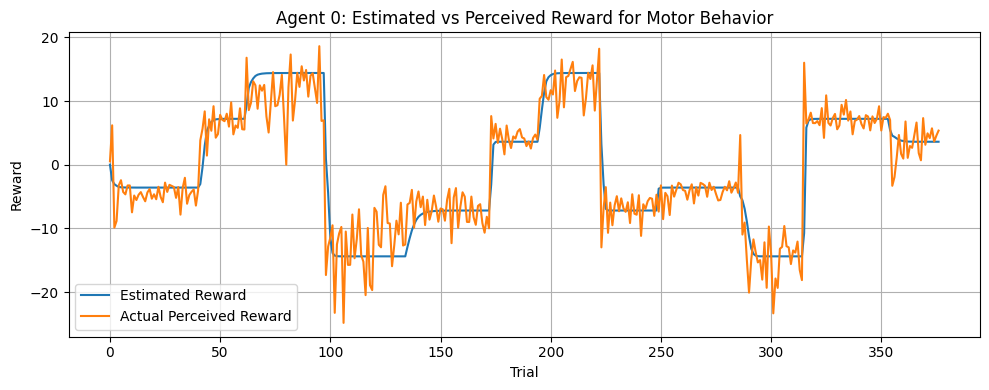

Agent 1 — estimated reward range: -14.399988384199842 14.4


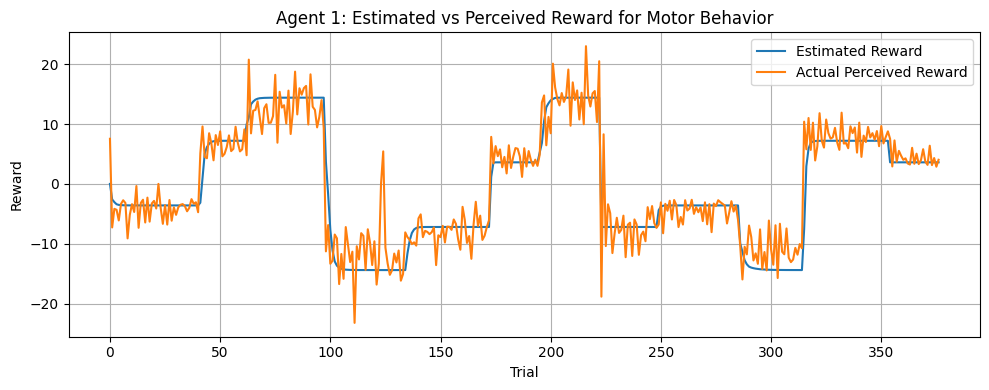

Agent 2 — estimated reward range: -14.399999999972106 14.399875866798395


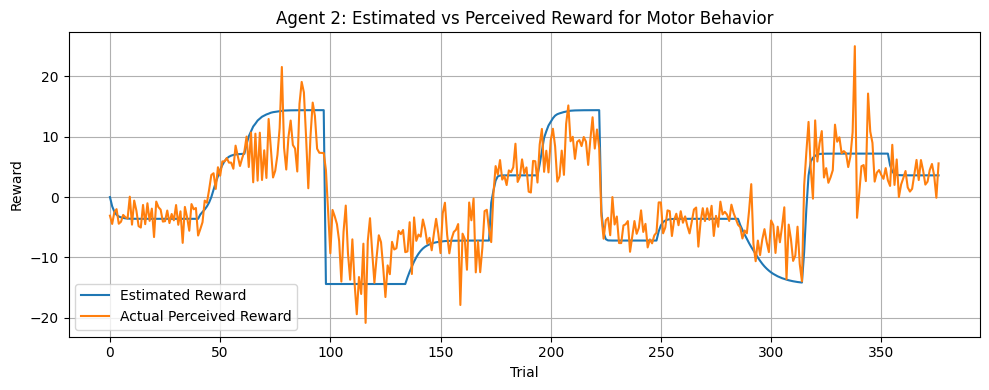

Agent 3 — estimated reward range: -14.4 14.4


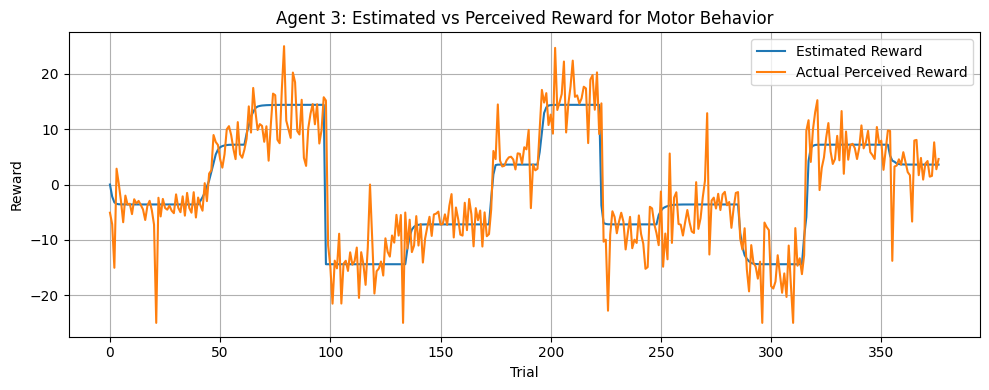

Agent 4 — estimated reward range: -14.39986648898637 14.39995385312553


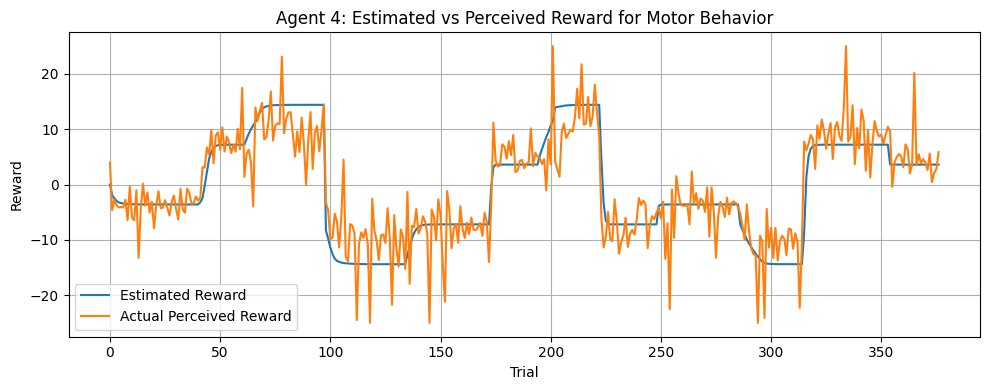

Agent 5 — estimated reward range: -14.4 14.399991662362705


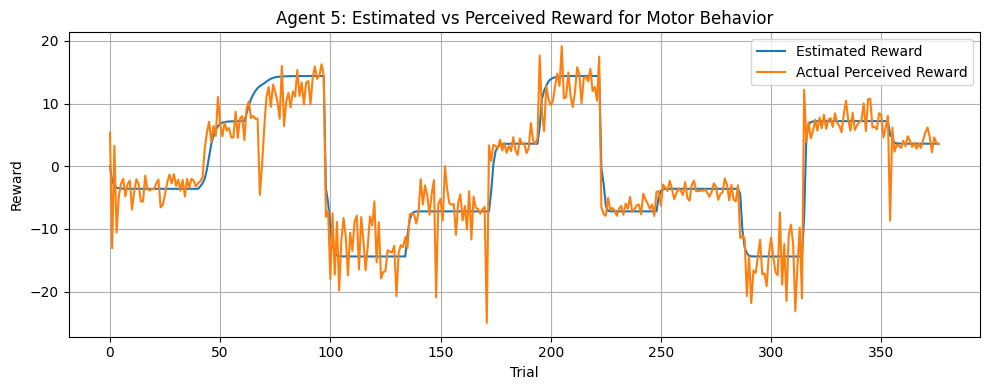

Agent 6 — estimated reward range: -14.399999999999919 14.4


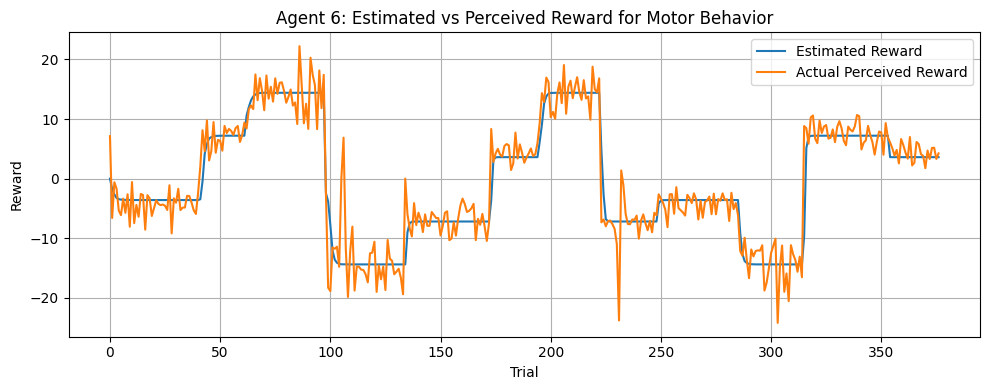

Agent 7 — estimated reward range: -14.399973500522705 14.399999853877222


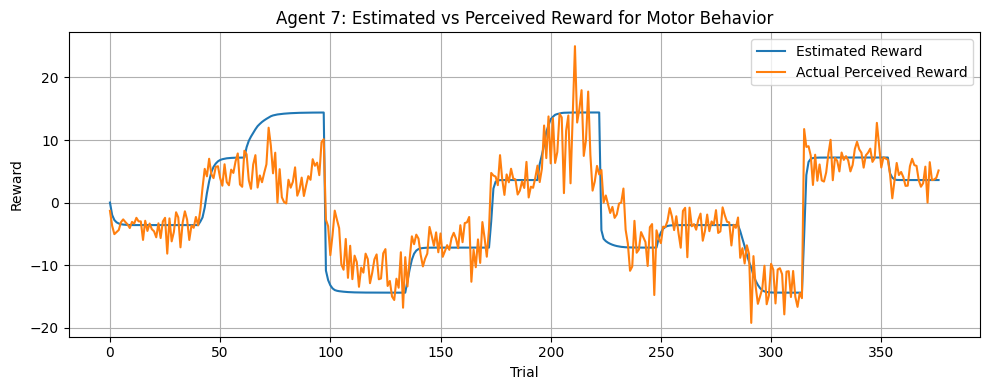

Agent 8 — estimated reward range: -14.4 14.399994926913259


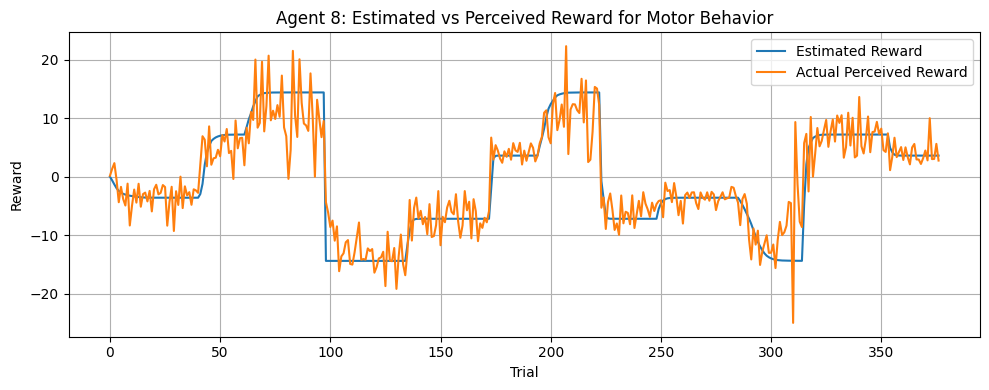

Agent 9 — estimated reward range: -14.399322900168562 14.39772788630556


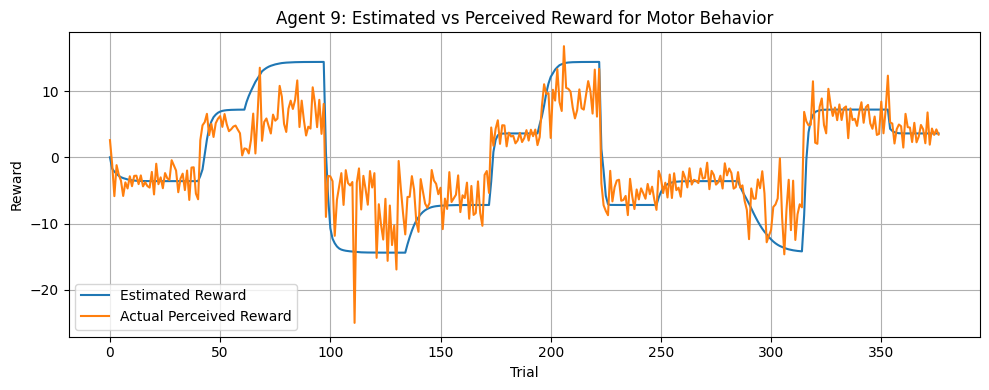

Agent 10 — estimated reward range: -14.399999999997101 14.399997136301488


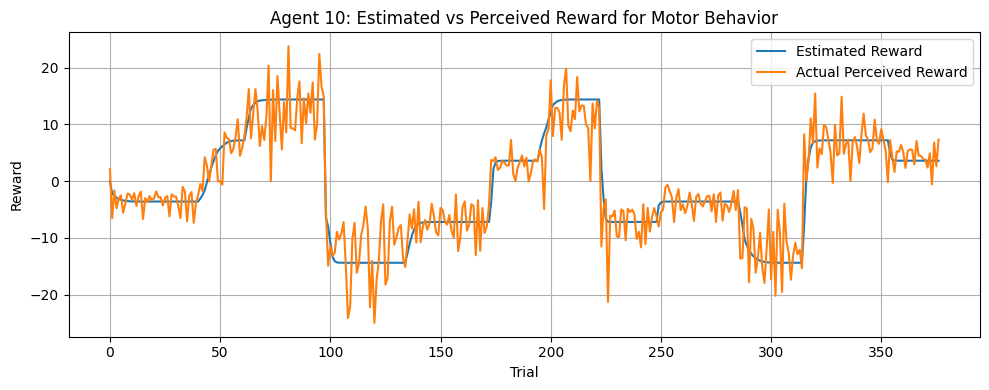

Agent 11 — estimated reward range: -14.4 14.3999999757048


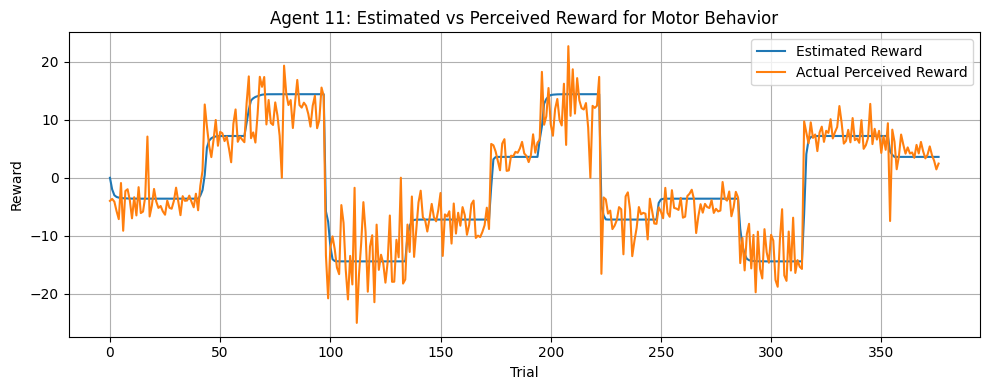

Agent 12 — estimated reward range: -14.399999962323413 14.399986556607308


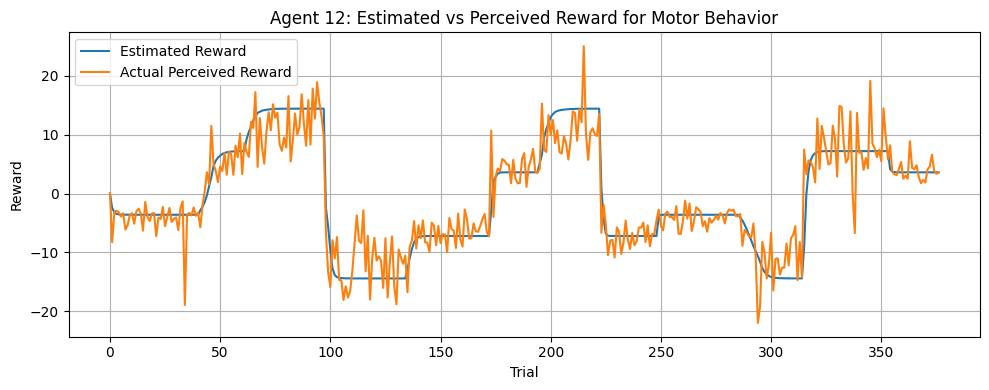

Agent 13 — estimated reward range: -14.393394514425069 14.399951115433424


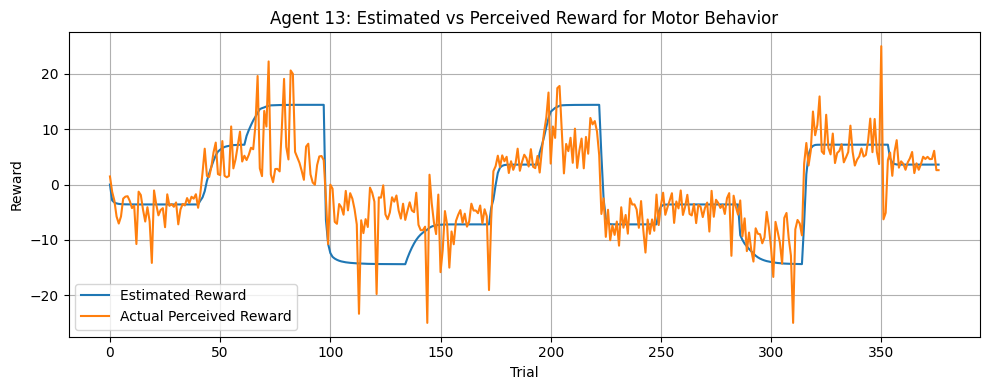

Agent 14 — estimated reward range: -14.386175852888783 14.39918415753801


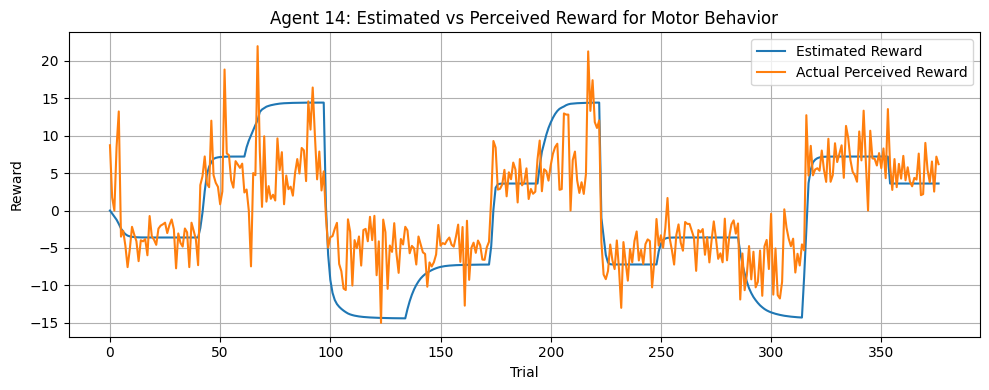

Agent 15 — estimated reward range: 0.0 0.0


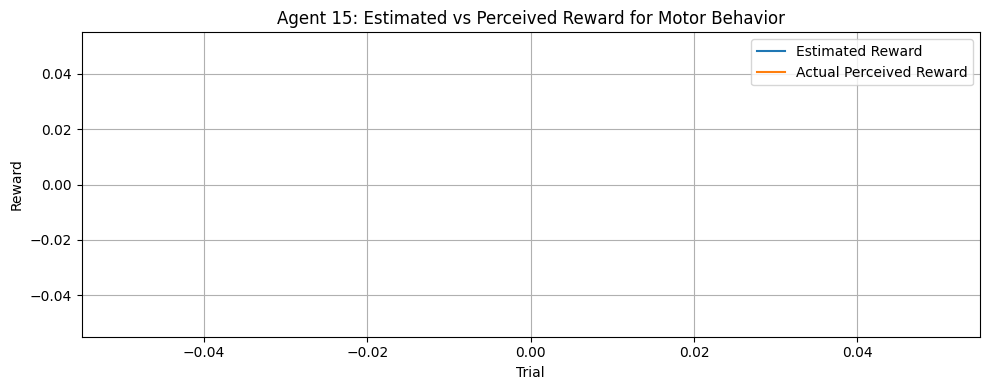

Agent 16 — estimated reward range: -14.39999999859731 14.399998106795296


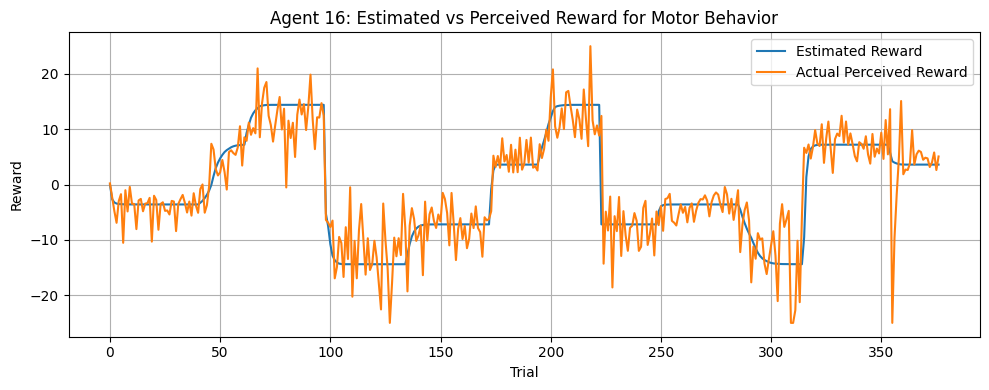

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for agent_id in df['agent_id'].unique():
    agent_df = df[df['agent_id'] == agent_id]
    print(f"Agent {agent_id} — estimated reward range:",
          agent_df['estimated_reward'].min(),
          agent_df['estimated_reward'].max())

    plt.figure(figsize=(10, 4))
    plt.plot(agent_df['trial'], agent_df['estimated_reward'], label='Estimated Reward')
    plt.plot(agent_df['trial'], agent_df['participant_perceived_reward'], label='Actual Perceived Reward')
    plt.title(f"Agent {agent_id}: Estimated vs Perceived Reward for Motor Behavior")
    plt.xlabel("Trial")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 🔽 Save the plot as PNG
    plt.savefig(f"agent_{agent_id}_reward_plot.png", dpi=300)

    # Optional: also show it
    plt.show()
import zipfile
import os
from google.colab import files

with zipfile.ZipFile("all_agent_plots_Motor.zip", "w") as zipf:
    for agent_id in df['agent_id'].unique():
        filename = f"agent_{agent_id}_reward_plot.png"
        if os.path.exists(filename):
            zipf.write(filename)
files.download("all_agent_plots_Motor.zip")